# Mouse line analysis

In [2]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The skip_kernel_extension extension is already loaded. To reload it, use:
  %reload_ext skip_kernel_extension


## Imports

In [3]:
# External packages
import logging
import os
import jupyter_slack
import datetime
import itertools
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
from statannotations.Annotator import Annotator

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *
from parsers import extract_FOV_area

# Figures dictionary
figs = {}

## Parameters

### Input datasets and main processing parameters

In [4]:
# Processing parameters
analysis_type = 'main'  # Analysis type
mouseline = 'pv'  # mouse line
layer = None  # cortical layer
slack_notify = False
global_correction = GLOBAL_CORRECTION  # global stack correction method
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection

# Plotting parameters
xkeys_plt = [  # input parameters
    Label.P,
    Label.DC,
    Label.ISPTA
]
ykeys_plt = [  # plotting variables
    Label.DFF,
    Label.ZSCORE, 
    # Label.EVENT_RATE
]
plot_rasters = False  # whether to render raster plots of population activity, or not
plot_traces = True  # whether to render traces of population activity, or not

### Derived parameters

In [5]:
# If global correction is dictionary, extract line-specific method
if isinstance(global_correction, dict):
    global_correction = global_correction[mouseline]

# Get batch-related settings
dataset_group_id, input_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, global_correction, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_id = get_baseline_id(baseline_quantile, baseline_wquantile, baseline_wsmoothing)

ispv = mouseline == 'pv'
isnotpv = not ispv

# Set ON/OFF execution flags
skip_rasters = not plot_rasters
skip_traces = not plot_traces
 
# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2024/03/26 14:55:55: assembling batch analysis settings...
 2024/03/26 14:55:55: pv main analysis notebook started on 2024-03-26 at 14:55:55


### Input summary table figure

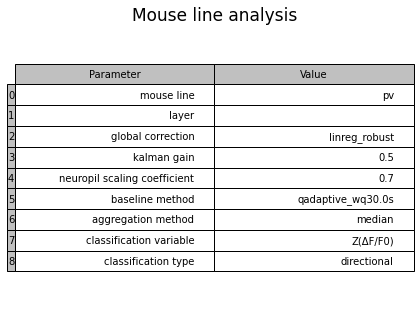

In [6]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'global correction': global_correction,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline method': baseline_id,
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional",
    }, title='Mouse line analysis', aspect=1.5)

## Load & inspect initial data

### Load data

In [7]:
# Determine exclude patterns
# from excludes import main_excludes
# exclude_patterns = list(set(main_excludes[mouseline]))
exclude_patterns = None

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop'

# Load datasets
logger.info(f'loading data from {input_dir}:')
data = load_processed_datasets(
    input_dir, layer=layer,
    exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs)
logger.info('data successfully loaded.')

 2024/03/26 14:56:00: loading data from /gpfs/scratch/lemait01/data/usnm/processed/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_robust/submap_0<-1_9->10every100/main/pv:
 2024/03/26 14:56:00: gathering dataset IDs...
 2024/03/26 14:56:01: loading mouse-region data from 20190606_mouse2_region1.h5
 2024/03/26 14:56:01: loading mouse-region data from 20190606_mouse2_region2.h5
 2024/03/26 14:56:01: loading mouse-region data from 20190629_mouse2_region1.h5
 2024/03/26 14:56:01: loading mouse-region data from 20190630_mouse3_region1.h5
 2024/03/26 14:56:01: loading mouse-region data from 20190702_mouse1_region1.h5
 2024/03/26 14:56:01: loading mouse-region data from 20190702_mouse5_region1.h5
 2024/03/26 14:56:01: loading mouse-region data from 20190703_mouse4_region1.h5
 2024/03/26 14:56:02: loading mouse-region data from 20190821_mouse3_region1.h5
 2024/03/26 14:56:02: loading mouse-region data from 20190821_mous

### Unpack data and get ROI counts

In [8]:
# Unpack
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, map_ops = extract_from_batch_data(data)

# # TEMPORARY FIX: Offset population-aggregated traces by their median values
# logger.warning('TEMP FIX: computing ΔF/F and z-score traces median values for each dataset & run...')
# ykeys_offset = [Label.DFF, Label.ZSCORE]
# ymeds = popagg_timeseries[ykeys_offset].groupby([Label.DATASET, Label.RUN]).median()
# logger.warning('TEMP FIX: offseting median values from traces...')
# popagg_timeseries[ykeys_offset] -= expand_to_match(ymeds, popagg_timeseries.index)

# Display ROI count per dataset & run, and highlight incomplete datasets
logger.info('detailed ROI count:')
get_detailed_ROI_count(trialagg_stats, style=True)

 2024/03/26 14:56:13: extracting timeseries and stats from data...
 2024/03/26 14:56:13: detailed ROI count:


run,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
P (MPa),0.00,0.05,0.10,0.20,0.40,0.60,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80
DC (%),50,50,50,50,50,50,05,10,20,30,40,50,60,70,80
dataset,,,,,,,,,,,,,,,
20190606_mouse2_region1,86,nan,nan,86,86,86,86,86,86,86,86,86,nan,nan,nan
20190606_mouse2_region2,106,nan,nan,106,106,106,106,106,106,106,106,106,nan,nan,nan
20190629_mouse2_region1,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111
20190630_mouse3_region1,170,170,170,170,170,170,170,170,170,170,170,170,170,170,170
20190702_mouse1_region1,196,196,196,196,196,196,196,196,196,196,196,196,196,196,196
20190702_mouse5_region1,143,143,143,143,143,143,143,143,143,143,143,143,143,143,143
20190703_mouse4_region1,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112


### Inspect cell maps and exclude outlier datasets 

 2024/03/26 14:56:16: sorted cell densities:
dataset
20190606_mouse2_region1    338.593495
20190821_mouse3_region1    381.901965
20190606_mouse2_region2    417.336168
20190629_mouse2_region1    437.021836
20190703_mouse4_region1    440.958970
20190821_mouse7_region1    444.896103
20190702_mouse5_region1    563.010113
20190821_mouse6_region1    566.947247
20190630_mouse3_region1    669.312722
20190702_mouse1_region1    771.678197
dtype: float64
 2024/03/26 14:56:16: plotting cell maps...


100%|██████████| 10/10 [00:00<00:00, 67.70it/s]

 2024/03/26 14:56:16: no exclusion criterion -> ignoring


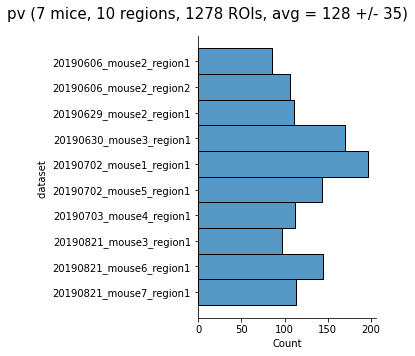

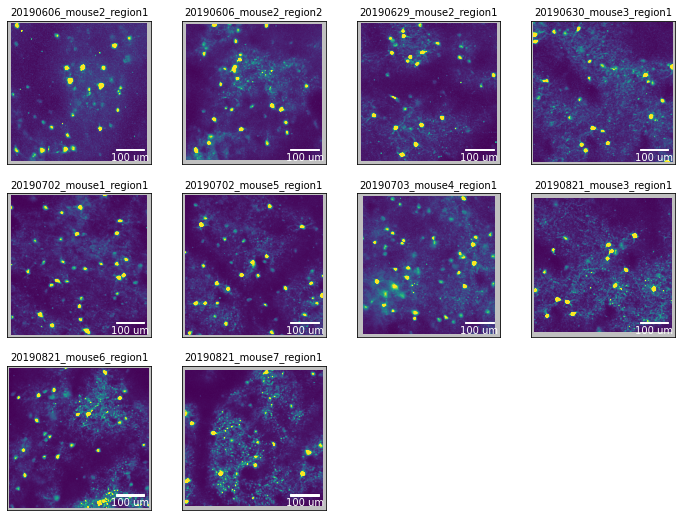

In [9]:
figs['cellcounts'] = plot_cellcounts(trialagg_stats, hue=None, title=mouseline)

# Compute ROI density for each dataset
FOV_areas = pd.Series({k: extract_FOV_area(v) for k, v in map_ops.items()})  # mm2
ROI_counts = get_detailed_ROI_count(trialagg_stats).max(axis=1).astype(int)  # cells
ROI_densities = ROI_counts / FOV_areas  # cells/mm2
logger.info(f'sorted cell densities:\n{ROI_densities.sort_values()}')

# If threshold on cell density is specified, exclude datasets with densities below threshold 
from constants import MIN_CELL_DENSITY
outliers = None
if MIN_CELL_DENSITY[mouseline] is not None:
    isoutlier = ROI_densities < MIN_CELL_DENSITY[mouseline]
    outliers = isoutlier[isoutlier].index.values.tolist()
    if len(outliers) > 0:
        logger.warning(f'datasets with abnormally low cell density::\n{pprint.pformat(outliers)}')
    figs['cellcounts'].axes[0].axvline(
        MIN_CELL_DENSITY[mouseline] * FOV_areas.mean(), c='k', ls='--')

# Plot cell maps and highlight outlier datasets
figs['cellmaps'] = plot_fields_of_view(
    map_ops, 
    refkey='max_proj',
    # ROI_masks=ROI_masks, 
    Fstats=trialagg_stats, 
    mode='contour', 
    hue=None, 
    outliers=outliers,
    qmax=.99
)

# Exclude outlier datasets
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = filter_datasets(
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, exclude=outliers)

### Inspect baseline variation throughout experiments and exclude outlier datasets

 2024/03/26 14:56:19: inspecting relative variations in baseline fluorescence across experiments...
 2024/03/26 14:56:20: maximal relative FO deviations:
dataset
20190630_mouse3_region1    0.045379
20190606_mouse2_region1    0.045463
20190606_mouse2_region2    0.046059
20190702_mouse1_region1    0.051029
20190821_mouse6_region1    0.061354
20190702_mouse5_region1    0.069364
20190703_mouse4_region1    0.120315
20190629_mouse2_region1    0.141263
20190821_mouse7_region1    0.144792
20190821_mouse3_region1    0.267499
Name: rel F0 (a.u.), dtype: float64


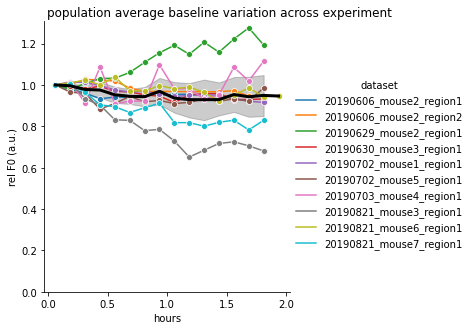

In [10]:
from constants import MAX_F0_REL_DEV
runid_maps = trialagg_stats[Label.RUNID].groupby([Label.DATASET, Label.RUN]).first()

def get_rel_F0(data, F0_key=Label.F0, aggbyrun=True):
    ''' Extract temporal evolution of F0 over experiment '''
    # Figure out dataset ID and associated run order
    dataset_id = data.index.unique(Label.DATASET)[0]
    # Extract frame rate from stats
    fps = get_singleton(trialagg_stats, Label.FPS)
    # Add time along entire experiment to population-average dataframe average
    idx = get_index_along_experiment(data.index, runid_map=runid_maps.loc[dataset_id])
    data[Label.TIME] = idx / fps
    # If specified, aggregate by run
    if aggbyrun:
        data = data.groupby(Label.RUN).median()
    # Compute relative variation from max
    yref = data.sort_values(Label.TIME)[F0_key].iloc[0]
    # yref = data[F0_key].max()
    relF0_key = f'rel {F0_key}'
    data[relF0_key] = data[F0_key] / yref
    # Return data of interest
    return data[[Label.TIME, relF0_key]]

# Compute relative variation of average baseline along experiment, for each dataset
logger.info('inspecting relative variations in baseline fluorescence across experiments...')
aggbyrun = True
F0_key = Label.F0
relF0_key = f'rel {F0_key}'
popagg_F0_per_run = (
    popagg_timeseries
    .groupby(Label.DATASET)
    .apply(lambda x: get_rel_F0(x, F0_key=F0_key, aggbyrun=aggbyrun))
)
popagg_F0_per_run[Label.HOURS] = popagg_F0_per_run[Label.TIME] / 3600

# Compute relative deviations of relative baseline fluorescence from its mean value,
# for each dataset
popagg_relF0_mean = popagg_F0_per_run[relF0_key].groupby(Label.DATASET).mean()
popagg_relF0_reldevs = ((popagg_F0_per_run[relF0_key] - popagg_relF0_mean) / popagg_relF0_mean).abs()

# Identify datasets that have at least 1 large F0 relative deviation from mean
max_popagg_relF0_reldevs = popagg_relF0_reldevs.groupby(Label.DATASET).max()
logger.info(f'maximal relative FO deviations:\n{max_popagg_relF0_reldevs.sort_values()}')
is_relF0_outlier = max_popagg_relF0_reldevs > MAX_F0_REL_DEV

# Extract datasets with at least 1 outlier run
relF0_outliers = is_relF0_outlier[is_relF0_outlier].index.unique(Label.DATASET).values.tolist()

# Remove potential outlier datasets
nouts = len(relF0_outliers)
palette = None
if nouts > 0:
    relF0_outliers_str = '\n'.join([f'  - {x}' for x in relF0_outliers])
    logger.warning(f'identified {nouts} datasets with abnormal baseline fluorescence variations:\n{relF0_outliers_str}')
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = filter_datasets(
        trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, exclude=relF0_outliers)
    palette = get_binary_palette(popagg_F0_per_run, relF0_outliers)

# Plot time evolution of average baseline along experiment, for each dataset
pltkwargs = dict(
    x=Label.HOURS,
    y=relF0_key,
)
fg = sns.relplot(
    kind='line',
    data=popagg_F0_per_run,
    errorbar=None, 
    hue=Label.DATASET,
    marker='o',
    palette=palette,
    legend=palette is None,
    aspect=1.,
    height=3 if not aggbyrun else 4.5,
    col=Label.DATASET if not aggbyrun else None,
    col_wrap=4 if not aggbyrun else None,
    **pltkwargs,
)
sns.despine(fig=fg.figure)
figs['popavg F0 across experiment'] = fg.figure
fg.figure.suptitle('population average baseline variation across experiment', y=1.01)
for ax in fg.figure.axes:
    # ax.axhline(1 - MAX_F0_REL_VAR, ls='--', c='k')
    ax.set_ylim(0, ax.get_ylim()[1])
if aggbyrun:
    # Add average trace across valid datasets
    sns.lineplot(
        ax=ax,
        data=popagg_F0_per_run.drop(relF0_outliers),
        lw=3, color='k', legend=False, **pltkwargs
    )

### Plot ROI / neuropil fluorescence ratio

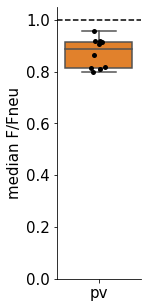

In [11]:
from plotters import plot_fluorescence_ratios
figs['F/Fneu'] = plot_fluorescence_ratios(popagg_timeseries, mouseline)

## Response curves

### Visualize global average trace, along with impact of exclusion criteria (on population-aggregated data)

 2024/03/26 14:56:24: plotting % of excluded samples per dataset, across criteria
 2024/03/26 14:56:24: computing population average data across (dataset, run, trial)...
 2024/03/26 14:56:25: adding time info to table...
 2024/03/26 14:56:25: identifying conditions with >= 5 valid trials
 2024/03/26 14:56:25: adding expanded validity index to timeseries ...
 2024/03/26 14:56:25: filtering timeseries ...
 2024/03/26 14:56:26: identified 140/2240 (6.2%) samples with "discarded" tag
 2024/03/26 14:56:26: identifying conditions with >= 5 valid trials
 2024/03/26 14:56:26: adding expanded validity index to timeseries ...
 2024/03/26 14:56:26: filtering timeseries ...
 2024/03/26 14:56:26: identified 25/2240 (1.1%) samples with "motion" tag
 2024/03/26 14:56:26: identifying conditions with >= 5 valid trials
 2024/03/26 14:56:26: adding expanded validity index to timeseries ...
 2024/03/26 14:56:26: filtering timeseries ...
 2024/03/26 14:56:27: identified 0/2240 (0.0%) samples with "pre-stim

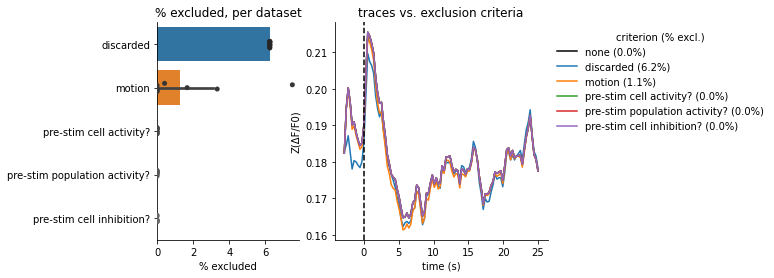

In [12]:
# Plot pct of exclusion per criterion and traces vs exclusion criteria
ykey = Label.ZSCORE
figs['impact of exclusion criteria'], axes = plt.subplots(
    1, 2, figsize=(7, 4), width_ratios=[1, 1.5])
plot_pct_excluded(ext_stats, ax=axes[0])
popagg_stats = get_popavg_data(ext_stats)
plot_traces_vs_exclusion(popagg_timeseries, popagg_stats, ykey, ax=axes[1]);

### Plot aggregate response trace for all non-zero conditions, and identify temporal response features and corresponding response analysis window

 2024/03/26 14:56:31: adding ['fps' 'duration (s)' 'P (MPa)' 'DC (%)' 'I_SPTA (W/cm2)'] information to timeseries...
 2024/03/26 14:56:35: adding time info to table...
 2024/03/26 14:56:35: plotting Z(ΔF/F0) response traces...
 2024/03/26 14:56:44: computing peak features on average trace...
 2024/03/26 14:56:44: response FWHM = 1.48s, corresponding window size = 1.40s (5 frames)
 2024/03/26 14:56:44: overwriting post window size in "/gpfs/scratch/lemait01/data/usnm/processed/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_robust/submap_0<-1_9->10every100/main/pv/post_window_size.txt"


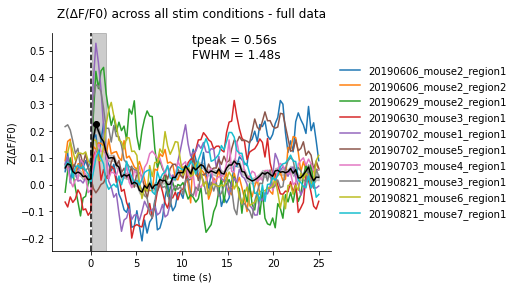

In [13]:
# Add critical stats columns to timeseries data
plt_data = get_plot_data(trialagg_timeseries, trialagg_stats)

# Variable of interest
ykey = Label.ZSCORE

# Flag to add per-dataset traces
dataset_traces = 'full' # 'grey'

# Extract plot data for all non-zero conditions
stim_cond = plt_data[Label.ISPTA] > 0
stim_pltdata = plt_data[stim_cond]

# Plot average trace across datasets
logger.info(f'plotting {ykey} response traces...')
figs[f'{ykey} resp trace merged'], ax = plt.subplots(figsize=(5, 4))
sns.despine(ax=ax)
if dataset_traces:
    sns.lineplot(
        ax=ax,
        data=stim_pltdata,
        x=Label.TIME,
        y=ykey,
        errorbar=None,
        hue=Label.DATASET,
        palette=get_uniform_palette(stim_pltdata) if dataset_traces == 'grey' else None,
        legend='full' if dataset_traces == 'full' else False,
    )
sns.lineplot(
    ax=ax,
    data=stim_pltdata,
    x=Label.TIME,
    y=ykey,
    errorbar='se',
    color='k' if dataset_traces == 'full' else Palette.LINE[mouseline],
)
ax.axvline(0, ls='--', c='k')
ax.set_title(f'{ykey} across all stim conditions - full data', y=1.05)

# Compute and materialize peak features on average trace
logger.info('computing peak features on average trace...')
fps = get_singleton(trialagg_stats, Label.FPS)
s = trialagg_timeseries[stim_cond][ykey].groupby(Label.FRAME).mean()
props = find_response_peak(
    s.loc[FrameIndex.STIM:], full_output=True, prominence=0.3 * np.ptp(s), width=1)
tprops = convert_peak_props(props, fps, ioffset=FrameIndex.STIM)
tpeak = tprops['index']  # s
ypeak = tprops['value']
FWHM = tprops['widths']  # s
ax.plot(tpeak, ypeak, 'o', c='k')
ax.axvspan(tprops['left_ips'], tprops['right_ips'], color='k', alpha=.2, label='FWHM')

# Mark peak features on figure
txt = [
    f'tpeak = {tpeak:.2f}s',
    f'FWHM = {FWHM:.2f}s',
]

# Compute post-stimulus window size (i.e. number of frames) from extracted FWHM, and save it to file
npost = int(np.round(props['widths']))
logger.info(f'response FWHM = {FWHM:.2f}s, corresponding window size = {npost / fps:.2f}s ({npost} frames)')
save_post_window_size(input_dir, npost)

# Add text on axis and legend on right side
ax.text(0.5, 1, '\n'.join(txt), transform=ax.transAxes, va='top', fontsize=12)
if ax.get_legend() is not None:
    sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5), frameon=False)

### Plot response traces for each parametric sweep (1 axis per condition)

 2024/03/26 14:56:46: plotting Z(ΔF/F0) vs. P (MPa) response traces...
 2024/03/26 14:56:59: plotting Z(ΔF/F0) vs. DC (%) response traces...


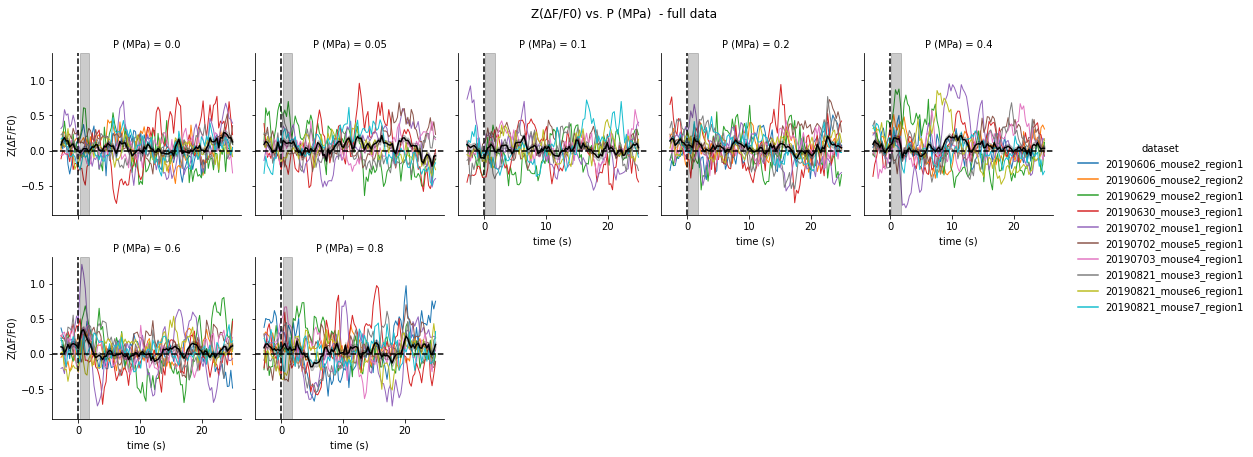

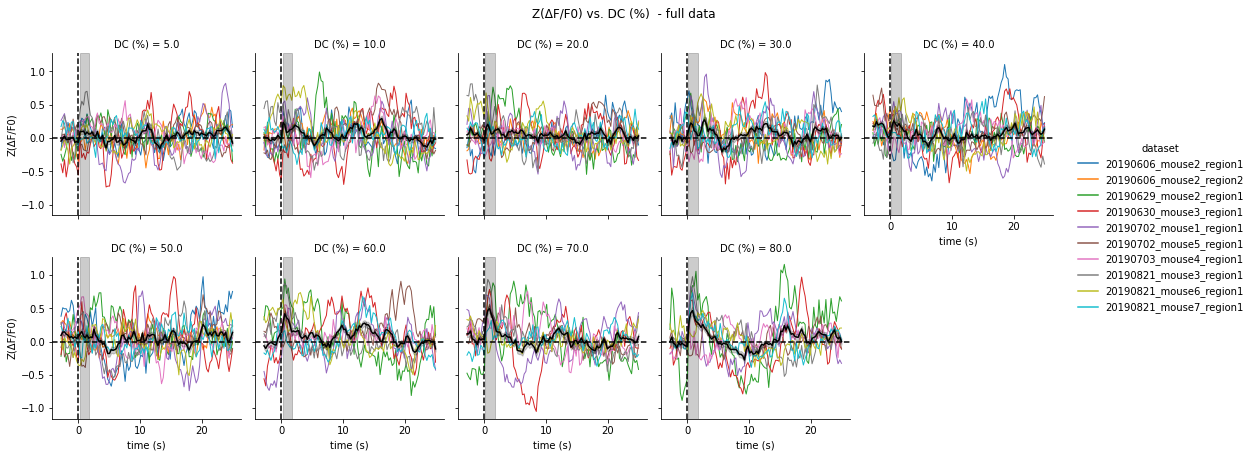

In [14]:
%%skip $skip_traces

# Variable of interest
ykey = Label.ZSCORE

# Flag to add per-dataset traces
dataset_traces = 'full'  # 'grey'

# Facetgrid kwargs
fgkwargs = dict(
    kind='line',
    col_wrap=5,
    height=3,
)

# For each input parameter
for xkey in [Label.P, Label.DC]:
    logger.info(f'plotting {ykey} vs. {xkey} response traces...')

    # Plot average traces for each dataset and sweep value, if requested
    if dataset_traces:
        # Plot average trace for each sweep value
        g = sns.relplot(
            data=get_xdep_data(plt_data, xkey),
            x=Label.TIME,
            y=ykey,
            col=xkey,
            hue=Label.DATASET,
            palette=get_uniform_palette(g.data) if dataset_traces == 'grey' else None,
            legend='full' if dataset_traces == 'full' else False,
            errorbar=None, 
            lw=1,
            zorder=-1,
            **fgkwargs
        )
    
    # Plot global average trace for each sweep value
    pltkwargs = dict(
        x=Label.TIME, 
        y=ykey,
        color='k' if dataset_traces == 'full' else Palette.LINE[mouseline],
        errorbar='se',
    )
    if dataset_traces:
        g.map_dataframe(sns.lineplot, **pltkwargs)
    else:
        g = sns.relplot(
            data=get_xdep_data(plt_data, xkey),
            col=xkey,
            **pltkwargs,
            **fgkwargs
        )
    
    # Add vertical line at stimulus onset, and horizontal line at 0 
    g.refline(x=0, y=0, c='k')
    for ax in g.axes:
        ax.axvspan(tprops['left_ips'], tprops['right_ips'], color='k', alpha=.2)

    # Add title
    g.fig.suptitle(f'{ykey} vs. {xkey}  - full data', y=1.05)
    figs[f'{ykey} resp traces vs. {xkey} ext.'] = g.fig

### Plot response traces for each parametric sweep (1 axis per sweep)

 2024/03/26 14:57:20: sub-indexing data...
 2024/03/26 14:57:20: filtering data...
 2024/03/26 14:57:20: cross-checking filters...
 2024/03/26 14:57:20: grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 2024/03/26 14:57:22: sub-indexing data...
 2024/03/26 14:57:22: filtering data...
 2024/03/26 14:57:22: cross-checking filters...
 2024/03/26 14:57:23: grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...
 2024/03/26 14:57:25: sub-indexing data...
 2024/03/26 14:57:25: filtering data...
 2024/03/26 14:57:25: cross-checking filters...
 2024/03/26 14:57:25: grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 2024/03/26 14:57:28: sub-indexing data...
 2024/03/26 14:57:28: filtering data...
 2024/03/26 14:57:28: cross-checking filters...
 2024/03/26 14:57:28: grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


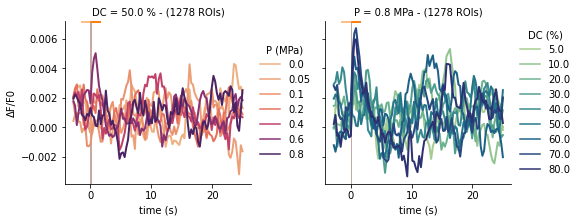

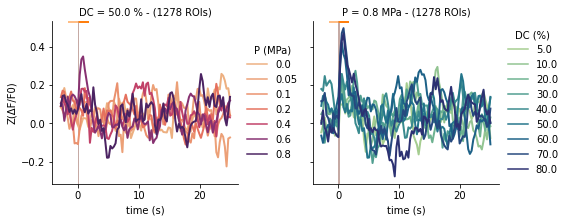

In [15]:
%%skip $skip_traces

# Determine input parameters
pkeys = [Label.P, Label.DC]

# Determine whether to group by responder type or not
groupby = None #Label.ROI_RESP_TYPE

# # Align DFF and z-score traces w.r.t their pre-stimulus average
# plt_data.loc[:, [Label.DFF, Label.ZSCORE]] = align_at(
#     plt_data[[Label.DFF, Label.ZSCORE]], get_window_slice(kind='pre'))

# For each output variable
for ykey in ykeys_plt:

    # # Pressure-dependent and duty cycle dependent response traces, per dataset
    # for pkey in pkeys:
    #     figs.update(
    #         plot_responses_across_datasets(
    #             plt_data, ykey=ykey, pkey=pkey, groupby=groupby))

    # Global (weighted) response curves for both input stimulation parameters
    avgaxes = []
    if groupby is None:
        figs[f'{ykey} resp traces'], axes = plt.subplots(
            1, len(pkeys), figsize=(4 * len(pkeys), 3), 
            sharey=True, gridspec_kw=dict(wspace=.4))
    else:
        axes = [None] * len(pkeys)
    for pkey, ax in zip(pkeys, axes):
        fig = plot_responses_across_datasets(
            plt_data, 
            ykey=ykey, 
            pkey=pkey, 
            ax=ax, 
            avg=True, 
            groupby=groupby,
            wpre=FrameIndex.NPRE, 
            wpost=npost,
            wcolor=Palette.LINE[mouseline],
        )
        if ax is not None:
            sns.move_legend(
                ax, 'center left', bbox_to_anchor=(1, 0.5), frameon=False)
        else:
            if isinstance(fig, dict):
                figs.update(fig)
            else:
                figs[f'{ykey} resp traces vs. {pkey}'] = fig
                avgaxes += fig.axes
    if len(avgaxes) > 0:
        harmonize_axes_limits(avgaxes, axkey='y')

## Parameter dependency curves

### Compute and plot initial parameter dependency curves with appropriate response window size

 2024/03/26 14:57:33: applying mean function on ΔF/F0 in [5-11] index window across dataset, ROI, run
 2024/03/26 14:57:33: applying mean function on ΔF/F0 in [11-16] index window across dataset, ROI, run
 2024/03/26 14:57:33: computing evoked ΔF/F0 change...
 2024/03/26 14:57:33: applying mean function on Z(ΔF/F0) in [5-11] index window across dataset, ROI, run
 2024/03/26 14:57:33: applying mean function on Z(ΔF/F0) in [11-16] index window across dataset, ROI, run
 2024/03/26 14:57:33: computing evoked Z(ΔF/F0) change...
 2024/03/26 14:57:33: plotting ['evoked ΔF/F0 change', 'evoked Z(ΔF/F0) change'] stimulation parameters dependencies...
 2024/03/26 14:57:33: sub-indexing data...
 2024/03/26 14:57:33: filtering data...
 2024/03/26 14:57:33: cross-checking filters...
 2024/03/26 14:57:33: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 2024/03/26 14:57:34: sub-indexing data...
 2024/03/26 14:57:34: filtering data...
 2024/03/26 14:57:34: cross-ch

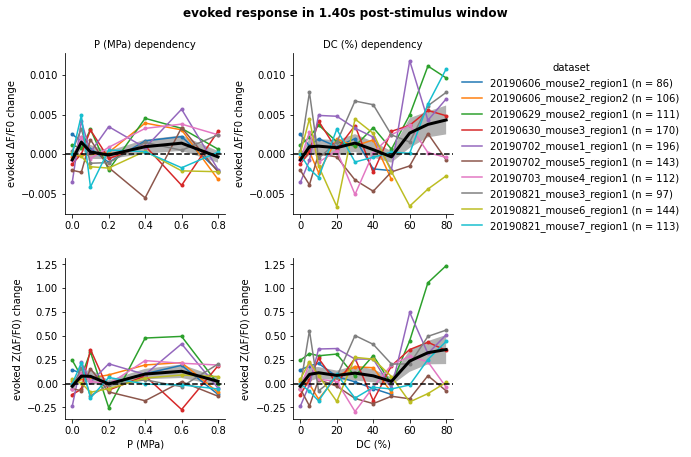

In [16]:
# Variables of interest
ykeys = [
    Label.DFF,
    Label.ZSCORE
]

# Whether to add detailed dataset traces
details = True

# Compute evoked responses for each variable of interest
for ykey in ykeys:
    ykey_diff = get_change_key(ykey)
    trialagg_stats[ykey_diff] = compute_evoked_change(
        trialagg_timeseries, 
        ykey, 
        npost=npost,  # Samples in determined post-stimulus window
    )

# Plot evoked response dependency on input parameters
figs['stimparams_init'] = plot_stimparams_dependency(
    trialagg_stats, 
    get_change_key(ykeys),
    xkeys=[Label.P, Label.DC],
    hue=Label.DATASET,
    palette='uniform' if not details else None,
    avgprop='whue', 
    avg_color='k' if details else 'line',
    errprop='inter',
    avgmarker='o',
    marker='.',
    errorbar=None,
)
figs['stimparams_init'].suptitle(
    f'evoked response in {npost / fps:.2f}s post-stimulus window', 
    fontsize=12, fontweight='bold', y=1.05)
if details:
    figs['stimparams_init'].subplots_adjust(wspace=.2)

### Temporary: Assess significance level of evoked responses

In [17]:
# # Define variable of interest
# ykey = Label.ZSCORE 
# ykey_diff = get_change_key(ykey)

# # Compute evoked change for rolling reference index
# logger.info(f'computing {ykey_diff} for rolling reference index...')
# resp_vs_iref = {}
# for iref in tqdm(np.arange(30, NFRAMES_PER_TRIAL - npost, step=3)):
#     resp_vs_iref[iref] = compute_evoked_change(
#         trialagg_timeseries, 
#         ykey, 
#         npost=npost,
#         iref=iref,
#         verbose=False,
#     )
# resp_vs_iref = pd.concat(
#     resp_vs_iref, names=['reference index'], axis=0).reset_index('reference index')

# # Compute summary statistics for evoked change in baseline periods
# logger.info(f'computing summary statistics for {ykey_diff} in baseline intervals...')
# resp_baseline_stats = resp_vs_iref[ykey_diff].agg({
#     'min': 'min',
#     '1%': lambda s: s.quantile(.01),
#     '5%': lambda s: s.quantile(.05),
#     'mean': 'mean',
#     'median': 'median',
#     '95%': lambda s: s.quantile(.95),
#     '99%': lambda s: s.quantile(.99),
#     'max': 'max',
#     'std': 'std',
# })

# # Plot distribution of evoked change for rolling reference index
# logger.info(f'plotting {ykey_diff} distribution in baseline intervals...')
# fig, ax = plt.subplots()
# sns.despine(ax=ax)
# ax.axhline(0, c='k', ls='--')
# sns.violinplot(
#     ax=ax,
#     data=resp_vs_iref.reset_index(),
#     y=ykey_diff,
#     cut=0,
# )
# ax.axvline(resp_baseline_stats['mean'], c='k')
# ax.axhspan(
#     resp_baseline_stats['mean'] - resp_baseline_stats['std'], 
#     resp_baseline_stats['mean'] + resp_baseline_stats['std'],
#     fc='k', alpha=0.3
# )
# ax.set_title(f'{ykey_diff} distribution for rolling reference index')

# # Plot evoked change dependency on reference index
# logger.info(f'plotting {ykey_diff} dependency on reference index...')
# fig, ax = plt.subplots()
# sns.despine(ax=ax)
# fig = plot_parameter_dependency(
#     resp_vs_iref, 
#     xkey='reference index',
#     ykey=ykey_diff,
#     hue=Label.DATASET,
#     palette='uniform' if not details else None,
#     avgprop='whue', 
#     avg_color='k',
#     errprop='inter',
#     avgmarker='o',
#     marker='.',
#     errorbar=None,
#     ax=ax,
# )

# # # Compute cross-dataset weighted mean and SEM across all reference index, and report it
# # logger.info(f'computing global cross-dataset weighted mean and SEM for {ykey_diff}...')
# # resp_vs_iref_agg = get_crossdataset_average(
# #     resp_vs_iref, 
# #     'reference index', 
# #     ykey=ykey_diff, 
# #     weighted=True, 
# #     errprop='inter',
# #     add_global_avg=False
# # ).set_index('reference index').mean()
# # mu_key, sem_key = get_propagg_keys(ykey)
# # ax.axhline(resp_vs_iref_agg[mu_key], c='k')
# # ax.axhspan(
# #     resp_vs_iref_agg[mu_key] - resp_vs_iref_agg[sem_key], 
# #     resp_vs_iref_agg[mu_key] + resp_vs_iref_agg[sem_key], 
# #     fc='k', ec=None, alpha=0.3
# # )

# # Plot evoked response dependency on input parameters
# fig = plot_stimparams_dependency(
#     trialagg_stats, 
#     ykey_diff,
#     xkeys=[Label.P, Label.DC],
#     avg_color=Palette.LINE[mouseline],
#     # hue=Label.DATASET,
#     # palette='uniform' if not details else None,
#     # avgprop='whue', 
#     # errprop='inter',
#     # avgmarker='o',
#     # marker='.',
#     # errorbar=None,
# )

# # Add shaded area to mark significance level of evoked change, 
# # based on evoked change distirbution in "baseline" 
# for ax in fig.axes:
#     # factor = pvalue_to_zscore(0.05)
#     # ax.axhline(resp_vs_iref_agg[mu_key], c='k')
#     # ax.axhspan(
#     #     resp_vs_iref_agg[mu_key] - factor * resp_vs_iref_agg[se_key], 
#     #     resp_vs_iref_agg[mu_key] + factor * resp_vs_iref_agg[se_key], 
#     #     fc='k', ec=None, alpha=0.3
#     # )
#     ax.axhline(resp_baseline_stats['mean'], c='k')
#     ax.axhspan(
#         resp_baseline_stats['5%'], 
#         resp_baseline_stats['95%'], 
#         fc='k', ec=None, alpha=0.3
#     )
#     ax.autoscale()
#     ax.autoscale_view()

### Inspect run presentation order per dataset and potential consequences on evoked activity

 2024/03/26 14:57:39: plotting I_SPTA (W/cm2) run sequence dependency across dataset...
 2024/03/26 14:57:39: run ID not part of (P (MPa), DC (%)) -> no filtering
 2024/03/26 14:57:39: sub-indexing data...
 2024/03/26 14:57:39: filtering data...
 2024/03/26 14:57:39: cross-checking filters...
 2024/03/26 14:57:39: grouping by dataset, averaging and plotting mean I_SPTA (W/cm2) vs. run ID ...
 2024/03/26 14:57:40: plotting evoked Z(ΔF/F0) change run sequence dependency across dataset...
 2024/03/26 14:57:40: run ID not part of (P (MPa), DC (%)) -> no filtering
 2024/03/26 14:57:40: sub-indexing data...
 2024/03/26 14:57:40: filtering data...
 2024/03/26 14:57:40: cross-checking filters...
 2024/03/26 14:57:40: grouping by dataset, averaging and plotting mean evoked Z(ΔF/F0) change vs. run ID ...
 2024/03/26 14:57:40: adding sample counts per dataset on legend labels...
 2024/03/26 14:57:40: parameter sequences across datasets:


dataset,20190606_mouse2_region1,20190606_mouse2_region2,20190629_mouse2_region1,20190630_mouse3_region1,20190702_mouse1_region1,20190702_mouse5_region1,20190703_mouse4_region1,20190821_mouse3_region1,20190821_mouse6_region1,20190821_mouse7_region1
run ID,,,,,,,,,,
0,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_40%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC
1,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_30%DC,0.80MPa_40%DC,NaN,0.80MPa_40%DC
2,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_20%DC,0.80MPa_30%DC,0.80MPa_40%DC,0.80MPa_30%DC
3,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_10%DC,0.80MPa_20%DC,0.80MPa_30%DC,0.80MPa_20%DC
4,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_05%DC,0.80MPa_10%DC,0.80MPa_20%DC,0.80MPa_10%DC
5,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.00MPa_50%DC,0.80MPa_05%DC,0.80MPa_10%DC,0.80MPa_05%DC
6,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.80MPa_05%DC,0.60MPa_50%DC
7,0.60MPa_50%DC,NaN,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.80MPa_60%DC,0.40MPa_50%DC
8,0.40MPa_50%DC,NaN,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.20MPa_50%DC,0.20MPa_50%DC,0.80MPa_70%DC,0.20MPa_50%DC


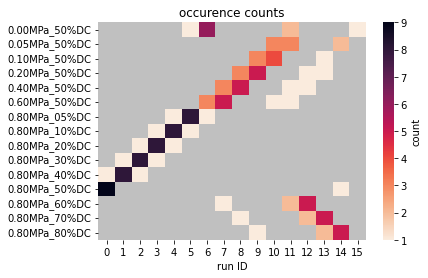

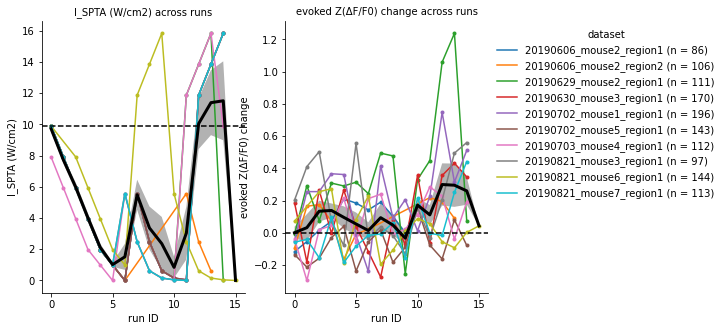

In [18]:
# Get parameter run sequence per dataset
param_seqs = trialagg_stats[[Label.RUNID, Label.P, Label.DC]].groupby([Label.DATASET, Label.RUNID]).first()
param_seqs = get_param_code(param_seqs).unstack().T

# Plot heatmap of occurence count across conditions and run IDs
params_counts = (param_seqs
    .apply(pd.Series.value_counts, axis=1)
    .fillna(0)
    .astype(int)
    .transpose()
)
figs['param count heatmap'], ax = plt.subplots()
ax.set_title('occurence counts')
cmap = sns.color_palette('rocket_r', as_cmap=True)
cmap.set_under('silver')
sns.heatmap(
    data=params_counts, 
    ax=ax, 
    cmap=cmap, 
    cbar_kws={'label': 'count'},
    vmin=1,
)

# Plot Ispta and evoked response across run sequences, per dataset
ykeys_seq = [Label.ISPTA, ykey_diff]
Ispta_ref = pressure_to_intensity(P_REF / PA_TO_MPA) / M2_TO_CM2 * DC_REF / 1e2
figs['rundeps_global'], axes = plt.subplots(1, len(ykeys_seq), figsize=(4 * len(ykeys_seq), 5))
for i, (ykey, ax) in enumerate(zip(ykeys_seq, np.atleast_1d(axes))):
    # Plot run sequence dependencies across datasets
    logger.info(f'plotting {ykey} run sequence dependency across dataset...')
    plot_parameter_dependency(
        trialagg_stats, 
        xkey=Label.RUNID, 
        ykey=ykey,
        yref=Ispta_ref if ykey == Label.ISPTA else 0., 
        hue=Label.DATASET, 
        errorbar=None, 
        avgprop='whue', 
        errprop='inter',
        ax=ax, 
        legend=i == len(ykeys_seq) - 1, 
        title=f'{ykey} across runs',
        marker='.',
    )

logger.info('parameter sequences across datasets:')
param_seqs

### Classify responses and responders

In [19]:
# Classify responses based on response z-score values
zthr = pvalue_to_zscore(PTHR_DETECTION, directional=directional)
trialagg_stats[Label.RESP_TYPE] = zscore_to_resp_type(
    trialagg_stats[ykey_diff], zthr, directional=directional)

# TODO: classify responders

 2024/03/26 14:57:43: classifying responses using directional z-score thresholding ...


### Plot evoked change distribution for control condition (P = 0)

 2024/03/26 14:57:44: response type proportions at P = 0:
response type
weak        95.774648
positive     4.225352
Name: count, dtype: float64


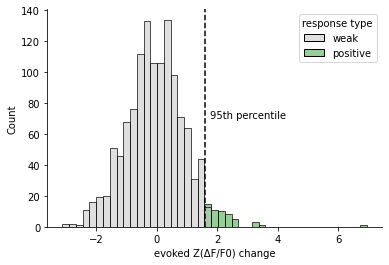

In [20]:
trialagg_stats0 = trialagg_stats[trialagg_stats[Label.P] == 0]
ykeydiff = get_change_key(Label.ZSCORE)

# Plot distribution of evoked response for baseline condition with response class color code
figs[f'{ykey_diff} dist baseline'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(
    ax=ax,
    data=trialagg_stats0,
    x=ykeydiff,
    hue=Label.RESP_TYPE,
    hue_order=get_default_rtypes(),
    palette=Palette.RTYPE
)
# Add 95th percentile location
q95 = trialagg_stats0[ykeydiff].quantile(.95)
ax.axvline(q95, c='k', ls='--')
ax.text(1.1 * q95, 0.5 * ax.get_ylim()[1], '95th percentile')

# Log responder fraction information
props0 = trialagg_stats0[Label.RESP_TYPE].value_counts() / len(trialagg_stats0) * 100
logger.info(f'response type proportions at P = 0:\n{props0}')

### Extract dictionary of fits per input parameters for current mouse line 

In [21]:
fit_dict = get_fit_table()[mouseline]
logger.info(f'fit_dict:\n{fit_dict}')

 2024/03/26 14:57:46: fit_dict:
parameter
P (MPa)                 scaled_power
DC (%)              threshold_linear
P_SPTA (MPa)        threshold_linear
P_SPTRMS (MPa)      threshold_linear
I_SPTA (W/cm2)      threshold_linear
I_SPTRMS (W/cm2)    threshold_linear
Name: pv, dtype: object


### Plot parameter dependency curves, with fits

 2024/03/26 14:57:47: plotting ['evoked ΔF/F0 change', 'evoked Z(ΔF/F0) change'] stimulation parameters dependencies...
 2024/03/26 14:57:47: sub-indexing data...
 2024/03/26 14:57:47: filtering data...
 2024/03/26 14:57:47: cross-checking filters...
 2024/03/26 14:57:47: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 2024/03/26 14:57:47: performing "evoked ΔF/F0 change ~ P (MPa)" type 1 ANOVA
 2024/03/26 14:57:47: no significant P (MPa) dependency -> avoiding fit
 2024/03/26 14:57:47: sub-indexing data...
 2024/03/26 14:57:47: filtering data...
 2024/03/26 14:57:47: cross-checking filters...
 2024/03/26 14:57:47: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. DC (%) ...
 2024/03/26 14:57:48: performing "evoked ΔF/F0 change ~ DC (%)" type 1 ANOVA
 2024/03/26 14:57:48: computing fit with threshold_linear function: p0 = [58, 0.00023, 0.08, -0.00071]
 2024/03/26 14:57:48: fitting results: popt = [45, 0.00012, 0.1, 0.00053], 

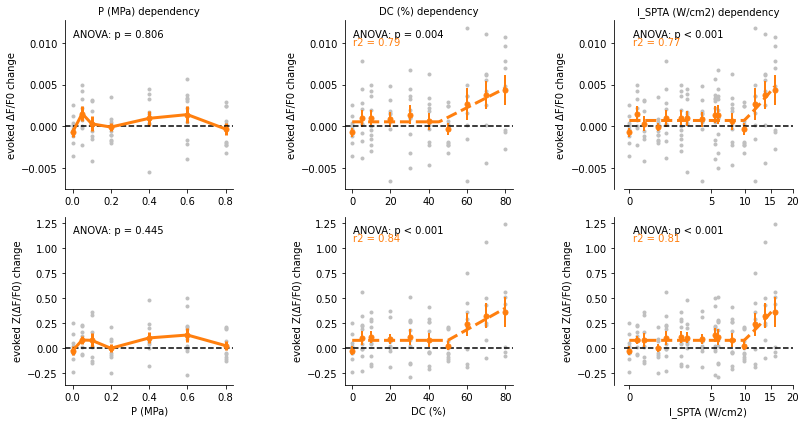

In [22]:
# Variables of interest
ykeys_resp = [get_change_key(k) for k in ykeys_plt] #+ [Label.RESP_FRAC]

# Plot evoked response dependency on input parameters, with fits
figs['stimparamdeps post curation'] = plot_stimparams_dependency(
    trialagg_stats,
    ykeys_resp,
    xkeys=xkeys_plt,  
    hue=Label.DATASET,
    palette='uniform',
    avgprop='whue', 
    avg_color='line',
    avgmarker='o',
    marker='.', 
    lw=0,
    errorbar=None,
    err_style='bars',
    fit=fit_dict,
)

### Plot P - DC alignment for various dose projections

 2024/03/26 14:57:54: computing ROI-weighted average of (10 datasets x 554 ROIs x 15 runs) "evoked ΔF/F0 change" series across run...
 2024/03/26 14:57:54: computing fit with threshold_linear function: p0 = [0.47, 0.029, 0.00064, -0.00071]
 2024/03/26 14:57:54: fitting results: popt = [0.4, 0.017, 0.00031, 0.00061], R2 = 0.82
 2024/03/26 14:57:55: computing fit with threshold_linear function: p0 = [12, 0.0012, 0.016, -0.00071]
 2024/03/26 14:57:55: fitting results: popt = [9.9, 0.0007, 0.0026, 0.00061], R2 = 0.82
 2024/03/26 14:57:55: computing fit with threshold_linear function: p0 = [13, 0.0022, 0.015, -0.00071]
 2024/03/26 14:57:55: fitting results: popt = [12, 0.0013, 0.0027, 0.0006], R2 = 0.83
 2024/03/26 14:57:55: computing ROI-weighted average of (10 datasets x 554 ROIs x 15 runs) "evoked Z(ΔF/F0) change" series across run...
 2024/03/26 14:57:55: computing fit with threshold_linear function: p0 = [0.46, 2.1, 0.00064, -0.027]
 2024/03/26 14:57:56: fitting results: popt = [0.4, 1

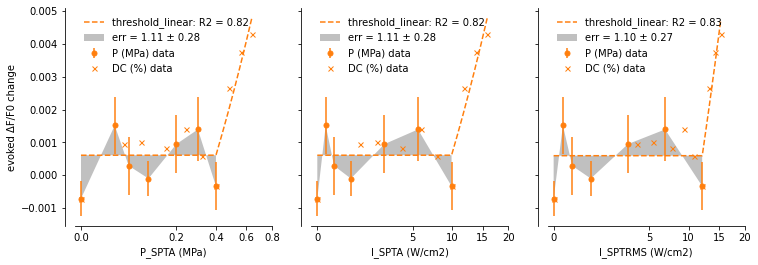

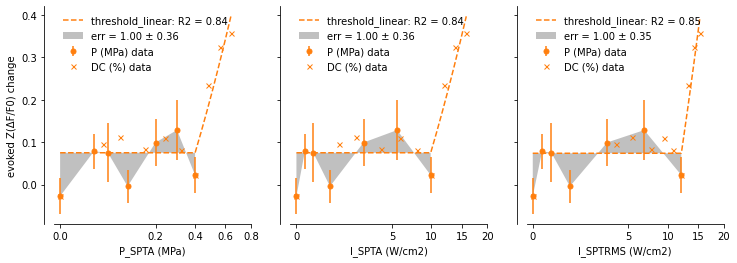

In [23]:
# Dose metrics
xkeys = [
    Label.PSPTA,
    Label.ISPTA,
    Label.ISPTRMS,
]

# Variables of interest
ykeys = [
    Label.DFF,
    Label.ZSCORE
]

# Dependent response variables
ykey_diffs = get_change_key(ykeys)

# Evaluate and plot alignment between DC sweep sigmoid predictors 
# and P sweep data
for ykey_diff in ykey_diffs:
    figs[f'resp alignment {ykey_diff}'] = plot_response_alignment(
        trialagg_stats,
        xkeys, 
        ykey_diff,
        fit_dict, 
        xscale='sqrt', 
        height=4,
    )   

### Comparison across layers (if applicable)

In [24]:
# dataset_ids = trialagg_stats.index.unique(Label.DATASET)
# layers = pd.Series(
#     [{True: 'layer5', False: 'layer2/3'}[s.endswith('layer5')] for s in dataset_ids],
#     index=dataset_ids,
#     name=Label.LAYER
# )
# logger.info(f'datasets count by layer:\n{layers.value_counts()}')
# if len(layers.value_counts()) > 1:
#     layer_palette = layers.map(
#         dict(zip(layers.unique(), mcolors.TABLEAU_COLORS.keys()))).to_dict()
#     trialagg_stats[Label.LAYER] = free_expand(layers, trialagg_stats)
#     fig = plot_stimparams_dependency(
#         trialagg_stats.copy(),
#         xkeys=xkeys_plt,
#         ykey=ykey_diff, 
#         hue=Label.DATASET,
#         hue_alpha=.5,
#         palette=layer_palette,
#         errorbar=None
#     )

#     plot_stimparams_dependency(
#         trialagg_stats.copy(),
#         xkeys=xkeys_plt,
#         ykey=ykey_diff, 
#         hue=Label.LAYER,
#         palette=layer_palette,
#         axes=np.array(fig.axes),
#         lw=10,
#         errorbar=None
#     )

## Response variability analysis (on valid trials)

### Get stats for valid trials

In [25]:
valid_stats = ext_stats[~ext_stats[Label.DISCARDED]]
valid_stats

line  trial_length  PRF (Hz)  \
dataset                 ROI run trial                                
20190606_mouse2_region1 2   0   1       pv           100     100.0   
                                2       pv           100     100.0   
                                3       pv           100     100.0   
                                4       pv           100     100.0   
                                5       pv           100     100.0   
...                                    ...           ...       ...   
20190821_mouse7_region1 890 14  11      pv           100     100.0   
                                12      pv           100     100.0   
                                13      pv           100     100.0   
                                14      pv           100     100.0   
                                15      pv           100     100.0   

                                       duration (s)   fps  P (MPa)  DC (%)  \
dataset                 ROI run trial                                        
20190606_mouse2_region1 2   0   1               0.2  3.56      0.0    50.0   
                                2               0.2  3.56      0.0    50.0   
                                3               0.2  3.56      0.0    50.0   
                                4               0.2  3.56      0.0    50.0   
                                5               0.2  3.56      0.0    50.0   
...                                             ...   ...      ...     ...   
20190821_mouse7_region1 890 14  11              0.2  3.56      0.8    80.0   
                                12              0.2  3.56      0.8    80.0   
                                13              0.2  3.56      0.8    80.0   
                                14              0.2  3.56      0.8    80.0   
                                15              0.2  3.56      0.8    80.0   

                                       run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  \
dataset                 ROI run trial                                           
20190606_mouse2_region1 2   0   1           6        0.000000         0.00000   
                                2           6        0.000000         0.00000   
                                3           6        0.000000         0.00000   
                                4           6        0.000000         0.00000   
                                5           6        0.000000         0.00000   
...                                       ...             ...             ...   
20190821_mouse7_region1 890 14  11         14       19.784475        15.82758   
                                12         14       19.784475        15.82758   
                                13         14       19.784475        15.82758   
                                14         14       19.784475        15.82758   
                                15         14       19.784475        15.82758   

                                       ...  baseline pre-stim avg Z(ΔF/F0)  \
dataset                 ROI run trial  ...                                   
20190606_mouse2_region1 2   0   1      ...                        0.673894   
                                2      ...                        0.016459   
                                3      ...                       -1.040600   
                                4      ...                        0.190192   
                                5      ...                       -0.711532   
...                                    ...                             ...   
20190821_mouse7_region1 890 14  11     ...                        2.075091   
                                12     ...                       -0.318101   
                                13     ...                       -0.815383   
                                14     ...                       -0.827898   
                                15     ...                        0.420232   

                                       base

### 2-way (ROI:TRIAL) ANOVA analysis

 2024/03/26 15:35:41: plotting ['ω²', 'p-value'] ANOVA stats across ['ROI', 'trial'] factors...
 2024/03/26 15:35:41: performing "F ~ C(I_SPTA (W/cm2))" type 1 ANOVA
 2024/03/26 15:35:41: performing "F ~ C(I_SPTA (W/cm2))" type 1 ANOVA
 2024/03/26 15:35:41: performing "F ~ run ID" type 1 ANOVA
 2024/03/26 15:35:41: performing "F ~ run ID" type 1 ANOVA
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

C(ROI) vs. C(trial): Mann-Whitney-Wilcoxon test two-sided, P_val:1.651e-33 U_stat=1.627e+03
 2024/03/26 15:35:41: performing "ω² ~ C(I_SPTA (W/cm2))" type 1 ANOVA
 2024/03/26 15:35:41: performing "ω² ~ C(I_SPTA (W/cm2))" type 1 ANOVA
 2024/03/26 15:35:41: performing "ω² ~ run ID" type 1 ANOVA
 2024/03/26 15:35:41: performing "ω² ~ run ID" type 1 ANOVA
 2024/03/26 15:35:41: performing "p-value ~ C(I_SPTA (W/cm2))" type 1 ANOVA
 2024/03/26 15:35:41: performing "p

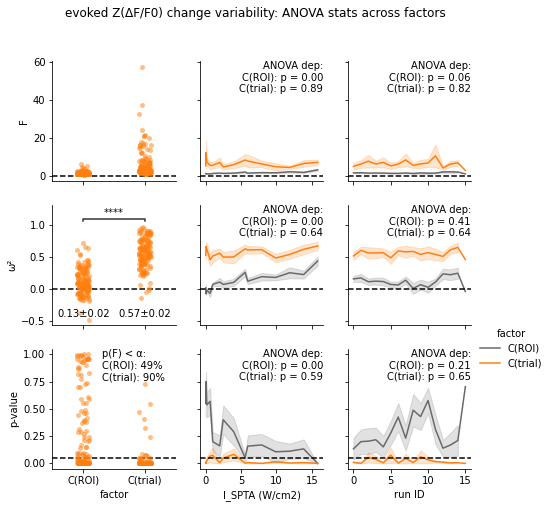

In [38]:
# Determing grouping variables
gby = [Label.DATASET, Label.RUN]

# Determine variable of interest
ykey_diff = get_change_key(Label.ZSCORE)

# Perform 2-way ANOVA on response strength across ROI and trials, across groups
factors = [Label.ROI, Label.TRIAL]
ANOVA_stats = anova(valid_stats, ykey_diff, factors, full_output=True, gby=gby, typ=1, interaction=False)
factor_pairs = list(itertools.combinations(ANOVA_stats.index.unique('factor').drop('Residual').values, 2))

# Add ISPTA and RUNID columns to ANOVA stats
logger.info('adding ISPTA and RUNID columns to ANOVA stats...')
run_stats = valid_stats[[Label.ISPTA, Label.RUNID]].groupby(gby).min()
ANOVA_stats = expand_to_match(run_stats, ANOVA_stats.index).join(ANOVA_stats)

# Compute proportion of significant factor dependencies for each factor
pvals = ANOVA_stats['p-value'].drop(index='Residual', level='factor').unstack('factor')
prop_sig_factors = (pvals < PTHR_DETECTION).sum() / len(pvals)
prop_sig_factors_str = '\n'.join(['p(F) < α:'] + [f'{k}: {v * 1e2:.0f}%' for k, v in prop_sig_factors.items()])

# Plot ANOVA stats (effect size and p-value) across factors, across ISPTA and run order
logger.info(f'plotting {ykeys} ANOVA stats across {factors} factors...')
xkeys = ['factor', Label.ISPTA, Label.RUNID]
palette = {
    parse_factor(Label.ROI, True): 'dimgray',
    parse_factor(Label.TRIAL, True): Palette.LINE[mouseline],
}
ykeys = ['F', 'ω²', 'p-value']
ythrs = {
    'F': 0,
    'ω²': 0,
    'p-value': PTHR_DETECTION,
}
height = 2.5
figs['resp anova stats'], axes = plt.subplots(
    len(ykeys), len(xkeys), 
    figsize=(height * len(xkeys), height * len(ykeys)), 
    sharey='row', sharex='col')
figs['resp anova stats'].suptitle(f'{ykey_diff} variability: ANOVA stats across factors')
pltkwargs = {'data': ANOVA_stats.drop(index='Residual', level='factor').reset_index()}
for axrow, yk in zip(axes, ykeys):
    pltkwargs['y'] = yk
    for ax, xk in zip(axrow, xkeys):
        sns.despine(ax=ax)
        pltkwargs.update(dict(
            x=xk,
            color=Palette.LINE[mouseline],
        ))
        # If x = factor, use stripplot to compare across factors
        if xk == 'factor':
            sns.stripplot(
                ax=ax,
                alpha=0.5,
                **pltkwargs
            )
            # For omega-squared, add statistical comparison between factors and mean +/- sem summary
            if yk == 'ω²':
                annotator = Annotator( 
                    ax,
                    factor_pairs, 
                    **pltkwargs)
                annotator.configure(test='Mann-Whitney')
                annotator.apply_and_annotate()
                wstats = ANOVA_stats[yk].groupby(xk).agg(['mean', 'sem']).drop('Residual')
                for i, (factor, (wmu, wsem)) in enumerate(wstats.iterrows()):
                    ax.text(i, -0.3, f'{wmu:.2f}±{wsem:.2f}', ha='center', va='top')
            # For p-values, add proportion of significant factors
            elif yk == 'p-value':
                ax.text(0.4, 1., prop_sig_factors_str, transform=ax.transAxes, va='top')
        # Otherwise, use lineplot to compare factors across ISPTA / run order
        else:
            pvals = {}
            for factor, subdata in pltkwargs['data'].groupby('factor'):
                pvals[factor] = anova(subdata, yk, xk, categorical=xk == Label.ISPTA)
            pvals_str = f'ANOVA dep:\n' + '\n'.join([f'{k}: p = {v:.2f}' for k, v in pvals.items()])
            ax.text(
                1.0, 1.0, pvals_str, 
                transform=ax.transAxes, ha='right', va='top')
            legend = yk == ykeys[-1] and xk == xkeys[-1]
            sns.lineplot(
                ax=ax,
                errorbar='se',
                hue='factor',
                palette=palette,
                legend=legend,
                **pltkwargs
            )
            if legend:
                sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 1), frameon=False)                
        ax.axhline(ythrs[yk], c='k', ls='--')
        if yk == 'reg pval':
            ax.set_ylim(-0.05, 1.05)

### Inter-trial variability

 2024/03/26 14:58:22: regressing evoked Z(ΔF/F0) change vs. trial across ['dataset', 'ROI', 'run']...


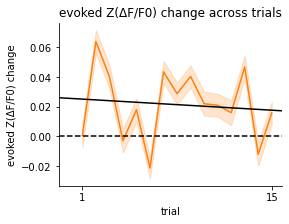

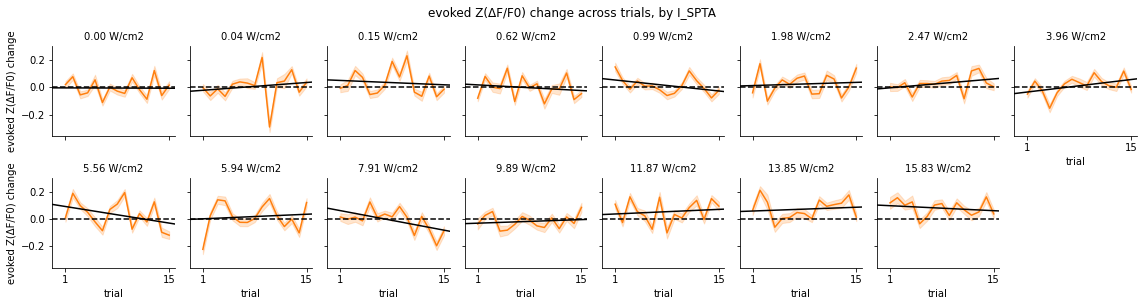

In [27]:
# Determine grouping variables
gby = [Label.DATASET, Label.ROI, Label.RUN]

# Determine variable of interest
ykey_diff = get_change_key(Label.ZSCORE)

# Regress response strength vs trial, acros groups
logger.info(f'regressing {ykey_diff} vs. {Label.TRIAL} across {gby}...')
regres = (
    valid_stats[ykey_diff]
    .groupby(gby)
    .apply(apply_linregress)
    .unstack(level=-1)
)

# Compute response variability statistics across trials, across groups
respvar = valid_stats[ykey_diff].groupby(gby).agg(['mean', 'std'])
respvar['cv'] = respvar['std'] / respvar['mean'].abs()

# Assemble into response statistics dataframe, and add ISPTA and RUNID columns to it 
resp_stats = pd.concat([
    valid_stats[[Label.ISPTA, Label.RUNID]].groupby(gby).min(),
    respvar,
    regres.add_prefix('reg '),
], axis=1)

# Aggregate response statistics across ROIs
agg_resp_stats = resp_stats.groupby([Label.DATASET, Label.RUN]).mean()
agg_resp_stats[Label.RUNID] = agg_resp_stats[Label.RUNID].astype(int)
agg_resp_stats[Label.ISPTA] = agg_resp_stats[Label.ISPTA].round(2)

# Plot variation in response strength across trials
trialbounds = valid_stats.index.unique(Label.TRIAL).sort_values()[[0, -1]].values
figs[f'{ykey_diff} vs trial'], ax = plt.subplots(figsize=(4, 3))
sns.despine(ax=ax)
ax.set_title(f'{ykey_diff} across trials')
sns.lineplot(
    ax=ax,
    data=valid_stats.reset_index(),
    x=Label.TRIAL,
    y=ykey_diff,
    color=Palette.LINE[mouseline],
    errorbar='se',
)
ax.axhline(0, c='k', ls='--')
ax.set_xticks(trialbounds)
# Add regression line
slope, intercept = resp_stats[['reg slope', 'reg intercept']].mean()
ax.axline([0, intercept], slope=slope, c='k')
figs[f'{ykey_diff} vs trial']

# Plot variation in response strength across trials, by ISPTA
colvar = Label.ISPTA
name, unit = parse_label(colvar)
trialbounds = valid_stats.index.unique(Label.TRIAL).sort_values()[[0, -1]].values
fg = sns.relplot(
    kind='line',
    data=valid_stats.reset_index(),
    x=Label.TRIAL,
    y=ykey_diff,
    color=Palette.LINE[mouseline],
    errorbar='se',
    col=colvar,
    col_wrap=8,
    height=2,
)
fg.set_titles('{col_name:.2f} ' + unit)
fg.refline(y=0, c='k')
for ax in fg.axes.flatten():
    ax.set_xticks(trialbounds)
# Add regression lines
for ax, (col, gdata) in zip(fg.axes.flatten(), resp_stats.groupby(colvar)):
    slope, intercept = gdata[['reg slope', 'reg intercept']].mean()
    ax.axline([0, intercept], slope=slope, c='k')
figs[f'{ykey_diff} vs trial by {name}'] = fg.fig
figs[f'{ykey_diff} vs trial by {name}'].suptitle(f'{ykey_diff} across trials, by {name}', y=1.05);

 2024/03/26 15:00:28: performing "cv ~ C(I_SPTA (W/cm2))" type 1 ANOVA
 2024/03/26 15:00:28: performing "cv ~ run ID" type 1 ANOVA
 2024/03/26 15:00:28: performing "reg slope ~ C(I_SPTA (W/cm2))" type 1 ANOVA
 2024/03/26 15:00:28: performing "reg slope ~ run ID" type 1 ANOVA
 2024/03/26 15:00:28: performing "reg pval ~ C(I_SPTA (W/cm2))" type 1 ANOVA
 2024/03/26 15:00:28: performing "reg pval ~ run ID" type 1 ANOVA


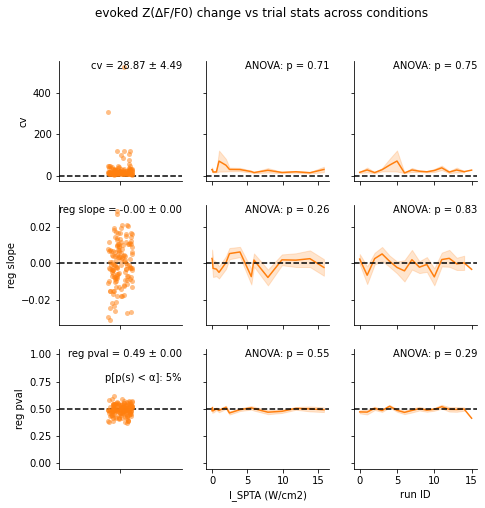

In [28]:
# Compute proportion of slopes that are significantly different from 0
prop_sig_slopes = (resp_stats['reg pval'] < PTHR_DETECTION).sum() / len(resp_stats['reg pval'])
prop_sig_slopes_str = f'p[p(s) < α]: {prop_sig_slopes * 1e2:.0f}%'

# Plot response vs trial statistics across ISPTA and run order
xkeys = [None, Label.ISPTA, Label.RUNID]
ykeys = ['cv', 'reg slope', 'reg pval']
ythrs = {
    'cv': 1.,
    'reg pval': 0.5,
    'reg slope': 0
}
height = 2.5
figs['resp vs trial stats'], axes = plt.subplots(
    len(ykeys), len(xkeys), 
    figsize=(height * len(xkeys), height * len(ykeys)), 
    sharey='row', sharex='col')
figs['resp vs trial stats'].suptitle(f'{ykey_diff} vs {Label.TRIAL} stats across conditions')
for axrow, yk in zip(axes, ykeys):
    for ax, xk in zip(axrow, xkeys):
        sns.despine(ax=ax)
        pltkwargs = dict(
            data=agg_resp_stats.reset_index(),
            ax=ax,
            y=yk,
            x=xk,
            color=Palette.LINE[mouseline],
        )
        if xk is None:
            sns.stripplot(
                alpha=0.5,
                **pltkwargs
            )
            ymu, ysem = pltkwargs['data'][yk].agg(['mean', 'sem'])
            ystr = f'{yk} = {ymu:.2f} ± {ysem:.2f}'
            ax.text(1., 1., ystr, transform=ax.transAxes, ha='right', va='top')
            if yk == 'reg pval':
                ax.text(1., .8, prop_sig_slopes_str, transform=ax.transAxes, ha='right', va='top')
        else:
            pval = anova(pltkwargs['data'], yk, xk, categorical=xk == Label.ISPTA)
            sns.lineplot(
                errorbar='se',
                **pltkwargs
            )
            ax.text(
                1.0, 1.0, f'ANOVA: p = {pval:.2f}', 
                transform=ax.transAxes, ha='right', va='top')
        ax.axhline(ythrs[yk], c='k', ls='--')
        if yk == 'reg pval':
            ax.set_ylim(-0.05, 1.05)

### Assess state-dependence of evoked activity

 2024/03/26 15:50:45: computing ['pre-stim avg Z(ΔF/F0)', 'evoked Z(ΔF/F0) change'] pairwise correlation coefficients...
 2024/03/26 15:50:45: computing ['baseline pre-stim avg Z(ΔF/F0)', 'baseline evoked Z(ΔF/F0) change'] pairwise correlation coefficients...
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

stimulus vs. baseline: t-test paired samples, P_val:1.012e-23 t=-1.024e+01


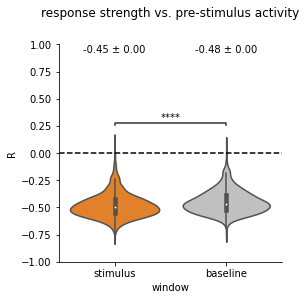

In [63]:
# Define variable of interest
ykey = Label.ZSCORE

# Extract pre, post and change keys
ykey_prestim, ykey_poststim, ykey_change = get_change_key(ykey, full_output=True)

# Define keys of variables to correlate / regress
xykeys = [ykey_prestim, ykey_change]

# Define grouping categories
gby = [Label.DATASET, Label.ROI]

# Define prefix and color for each window of interest
prefixes = {
    'stimulus': '', 
    'baseline': 'baseline '
}
cdict = {
    'stimulus': Palette.LINE[get_singleton(valid_stats, Label.LINE)],
    'baseline': 'silver'
}

# Initialize dict of correlation coefficients
corrcoeffs = {}

# For each analysis window
for wtype, prefix in prefixes.items():
    # Extract prefix and associated XY keys
    wkeys = [f'{prefix}{k}' for k in xykeys]

    # Compute Pearson correlation coefficient between pre- average and evoked change
    logger.info(f'computing {wkeys} pairwise correlation coefficients...')
    corrcoeffs[wtype] = (valid_stats
        .groupby(gby)
        [wkeys]
        .corr()
        .droplevel(-1)
        .iloc[::2, 1]
        .rename('R')
    )

# Convert correlation coefficients to dataframe
corrcoeffs = pd.concat(corrcoeffs, axis=0, keys=corrcoeffs.keys(), names=['window'])

# Create violin plot comparison of correlation coefficients
figs['prepost corr. comparison'], ax = plt.subplots(figsize=(4, 4))
sns.despine(ax=ax)
pltkwargs = dict(
    data=corrcoeffs.reset_index(),
    x='window',
    y='R',
    palette=cdict,
)
rstats = pltkwargs['data'].groupby('window')['R'].agg(['mean', 'sem'])
for i, (wtype, (rmu, rsem)) in enumerate(rstats.iterrows()):
    ax.text(i, 1.0, f'{rmu:.2f} ± {rsem:.2f}', ha='center', va='top')
sns.violinplot(**pltkwargs)
annotator = Annotator(ax, [tuple(cdict.keys())], **pltkwargs)
annotator.configure(test='t-test_paired', loc='outside')
annotator.apply_and_annotate()
ax.set_ylim(-1, 1)
ax.axhline(0, ls='--', c='k')
ax.set_title('response strength vs. pre-stimulus activity', y=1.1);

### Assess impact of stimulus intensity on state dependence

 2024/03/26 15:59:50: computing ['pre-stim avg Z(ΔF/F0)', 'evoked Z(ΔF/F0) change'] pairwise correlation coefficients...
 2024/03/26 15:59:50: regressing evoked Z(ΔF/F0) change on pre-stim avg Z(ΔF/F0)...
 2024/03/26 15:59:52: computing ['baseline pre-stim avg Z(ΔF/F0)', 'baseline evoked Z(ΔF/F0) change'] pairwise correlation coefficients...
 2024/03/26 15:59:52: regressing baseline evoked Z(ΔF/F0) change on baseline pre-stim avg Z(ΔF/F0)...
 2024/03/26 15:59:54: plotting R vs ISPTA...
 2024/03/26 16:00:03: plotting slope vs ISPTA...


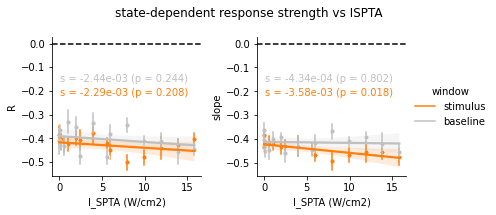

In [67]:
# Determine grouping categories
gby = [
    Label.DATASET, 
    # Label.ROI,
    Label.ISPTA, 
]

# Flag stating whether to compute linear regressions for pre vs. post comparison  
add_reg = True

# Initialize dict of output metrics
outmetrics = {}

# For each analysis window
for wtype, prefix in prefixes.items():
    # Initialize results list
    outmetrics[wtype] = []

    # Extract prefix and associated XY keys
    wkeys = [f'{prefix}{k}' for k in xykeys]

    # Compute Pearson correlation coefficient between pre-average and evoked change
    logger.info(f'computing {wkeys} pairwise correlation coefficients...')
    corrcoeffs = (valid_stats
        .groupby(gby)
        [wkeys]
        .corr()
        .droplevel(-1)
        .iloc[::2, 1]
        .rename('R')
    )
    outmetrics[wtype].append(corrcoeffs.to_frame())

    # If requested, compute linear regression on pre-stimulus average and change
    if add_reg:
        logger.info(f'regressing {wkeys[1]} on {wkeys[0]}...')
        regres = (valid_stats
            .groupby(gby)
            [wkeys]
            .apply(lambda df: apply_linregress(
                df, xkey=wkeys[0], ykey=wkeys[1], robust=True))
        )
        outmetrics[wtype].append(regres)
    
    # Concatenate output metrics
    outmetrics[wtype] = pd.concat(outmetrics[wtype], axis=1)

# Convert outputs to dataframe
outmetrics = pd.concat(outmetrics, axis=0, keys=outmetrics.keys(), names=['window'])

# Plot results vs ISPTA
keys = ['R', 'slope'] if add_reg else ['R']
figs['prepost vs ISPTA'], axes = plt.subplots(1, len(keys), figsize=(3 * len(keys) + 1, 3))
figs['prepost vs ISPTA'].suptitle('state-dependent response strength vs ISPTA')
axes = np.atleast_1d(axes)
for i, (ax, key) in enumerate(zip(axes, keys)):
    logger.info(f'plotting {key} vs ISPTA...')
    sns.despine(ax=ax)
    sns.lineplot(
        ax=ax,
        data=outmetrics.reset_index(),
        x=Label.ISPTA,
        y=key,
        hue='window',
        palette=cdict,
        err_style='bars',
        errorbar='se',
        marker='.',
        lw=0,
        markersize=10,
        legend=i == len(keys) - 1,
    )
    if ax.get_legend() is not None:
        sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5), frameon=False)
    if Label.ROI not in gby:
        robust = True
        ytxt = 0.7
        for wtype, wdata in outmetrics.groupby('window'):
            sns.regplot(
                ax=ax,
                data=wdata.reset_index(),
                x=Label.ISPTA,
                y=key,
                color=cdict[wtype],
                scatter=False,
                robust=robust,
            )
            df = apply_linregress(
                wdata,
                xkey=Label.ISPTA, 
                ykey=key, 
                robust=robust)
            regstr = f"s = {df['slope']:.2e} (p = {df['pval']:.3f})"
            ax.text(
                0.05, ytxt, regstr, color=cdict[wtype],
                transform=ax.transAxes, ha='left', va='center')
            ytxt -= 0.1
    ax.axhline(0, ls='--', c='k', zorder=-1)
figs['prepost vs ISPTA'].tight_layout()

### ROI breakdown per dataset

 2024/03/26 12:01:45: computing fraction of response occurence per ROI over 9 "strong ISPTA" conditions...
 2024/03/26 12:01:46: identified 3.1% of responders with 0.5 as threshold proportion of responding conditions
 2024/03/26 12:01:46: plotting cell maps...


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


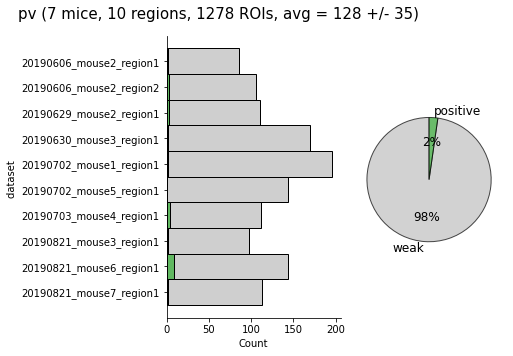

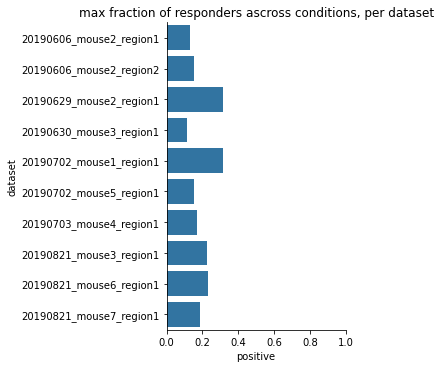

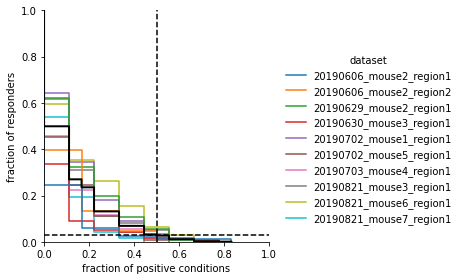

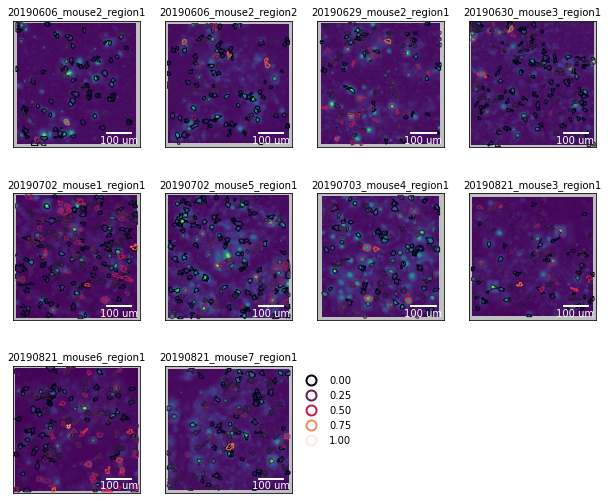

In [29]:
# Plot cell count distribution and breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(
    trialagg_stats, hue=Label.ROI_RESP_TYPE, title=mouseline)

# Plot distribution of max number of responders across conditions 
resp_counts = (
    trialagg_stats[Label.RESP_TYPE]
    .groupby([Label.DATASET, Label.RUN])
    .value_counts().unstack()
)
resp_counts['total'] = resp_counts.sum(axis=1)
resp_props = resp_counts.div(resp_counts['total'], axis=0)
max_pos_props= resp_props['positive'].groupby(Label.DATASET).max()
max_pos_props = max_pos_props.to_frame().reset_index()
fg = sns.catplot(
    data=max_pos_props,
    kind='bar', 
    x='positive', 
    y=Label.DATASET,
    color='C0'
)
fg.figure.axes[0].set_xlim(0, 1)
fg.figure.axes[0].set_title('max fraction of responders ascross conditions, per dataset')
figs['max % resp'] = fg.figure

# Plot cell classification details 
figs['classification details'] = plot_classification_details(
    trialagg_stats, pthr=PROP_CONDS_THR, hue=Label.DATASET)

# Plot cell maps
figs['cellmaps with rtype'] = plot_fields_of_view(
    map_ops, 
    ROI_masks=ROI_masks,
    Fstats=trialagg_stats, 
    refkey='Vcorr', 
    mode='contour', 
    hue='positive'
)

### Compute inter-ROI statistics

 2024/03/26 12:02:51: computing ROI centers...
 2024/03/26 12:02:51: computing pairwise distances between ROIs...
 2024/03/26 12:02:51: computing pairwise response correlations between ROIs...
 2024/03/26 12:02:51: assembling pairwise ROI stats dataframe...
 2024/03/26 12:02:52: plotting results


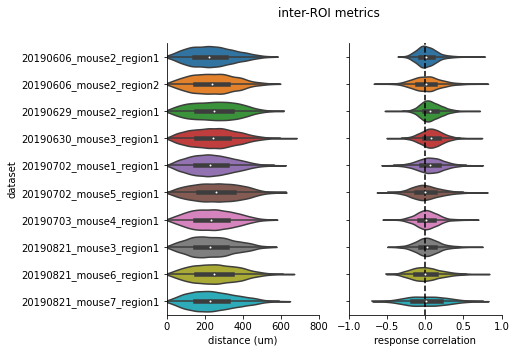

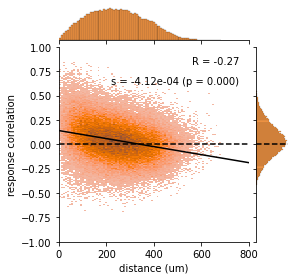

In [35]:
from scipy.spatial.distance import pdist, squareform

# Compute dataframe of ROIs "center of mass" coordinates
logger.info('computing ROI centers...')
gby = [Label.DATASET, Label.ROI]
weights = ROI_masks['lam']
wsum = weights.groupby(gby).sum()
ROI_centers = pd.DataFrame(index=wsum.index, columns=['x', 'y'])
for k in ['x', 'y']:
    ROI_centers[k] = (ROI_masks[f'{k}pix'] * weights).groupby(gby).sum() / wsum

# For each dataset, compute distance matrix between each ROI pair
logger.info('computing pairwise distances between ROIs...')
ROI_distances = {}
max_dists = pd.Series()
for dataset, coords in ROI_centers.groupby(Label.DATASET):
    coords = coords.droplevel(0)
    # Compute distance matrix
    dist = pd.DataFrame(
        data=squareform(pdist(coords, metric='euclidean')),
        index=coords.index,
        columns=coords.index
    )

    # Remove upper triangle (repeats) and diagonal (self-distances)
    dist = dist.where(np.triu(np.ones(dist.shape), k=1).astype(bool))

    # Serialize and remove self-distances
    dist = dist.unstack().dropna().rename('distance (pixels)')
    dist.index.names = ['ROI1', 'ROI2']

    # Convert to um
    um_per_pixel = map_ops[dataset]['micronsPerPixel']  # um/pix
    Lx, Ly = map_ops[dataset]['Lx'], map_ops[dataset]['Ly']
    dist = (dist * um_per_pixel).rename('distance (um)')

    # Compute maximal possible distance from FOV dimensions
    max_dists.loc[dataset] = np.sqrt(Lx**2 + Ly**2) * um_per_pixel
    
    # Append to dictionary
    ROI_distances[dataset] = dist

# Extract maximal possible distance across datasets, and round it to the nearest 100
dmax = max_dists.max()
dmax = np.ceil(dmax / 100) * 100

# Concatenate distance matrices
ROI_distances = pd.concat(ROI_distances, axis=0, keys=ROI_distances.keys(), names=[Label.DATASET])

# Compute cross-ROI correlations
logger.info('computing pairwise response correlations between ROIs...')
respcorrs = compute_crossROIs_correlations(
    ext_stats, ykey_diff, by=Label.DATASET).rename('response correlation')

# Assemble pairwise ROI stats dataframe
logger.info('assembling pairwise ROI stats dataframe...')
pairwise_ROI_stats = pd.concat([ROI_distances, respcorrs], axis=1)

logger.info('plotting results')

# Plot distributions of each pairwise, per dataset
keys = pairwise_ROI_stats.columns
ndatasets = len(pairwise_ROI_stats.index.unique(Label.DATASET))
figs['inter ROI metrics'], axes = plt.subplots(1, len(keys), figsize=(3 * len(keys), 0.5 * ndatasets))
figs['inter ROI metrics'].suptitle('inter-ROI metrics')
for i, (ax, k) in enumerate(zip(axes, keys)):
    sns.despine(ax=ax)
    sns.violinplot(
        data=pairwise_ROI_stats.reset_index(),
        x=k,
        y=Label.DATASET,
        split=True,
        cut=0,
        ax=ax
    )
    if i > 0:
        ax.set_ylabel(None)
        ax.set_yticklabels([])
    if k == 'response correlation':
        ax.set_xlim(-1, 1)
        ax.axvline(0, ls='--', c='k')
    elif k == 'distance (um)':
        ax.set_xlim(0, dmax)

# Plot joint distribution of distance and response correlation
jg = sns.jointplot(
    data=pairwise_ROI_stats, 
    x='distance (um)', 
    y='response correlation',
    kind='hist',
    height=4,
    color=Palette.LINE[mouseline],
)
jg.ax_joint.set_xlim(0, dmax)
jg.ax_joint.set_ylim(-1, 1)
for ax in [jg.ax_joint, jg.ax_marg_y]:
    ax.axhline(0., ls='--', c='k')
R = pairwise_ROI_stats.corr().iloc[0, 1]
jg.ax_joint.text(0.95, 0.95, f'R = {R:.2f}', transform=jg.ax_joint.transAxes, ha='right', va='top')
regres = apply_linregress(
    pairwise_ROI_stats, 
    xkey='distance (um)', 
    ykey='response correlation',
    robust=True,
)
dvec = np.array([0, dmax])
jg.ax_joint.plot(dvec, regres['slope'] * dvec + regres['intercept'], 'k')
jg.ax_joint.text(
    0.95, 0.85, f's = {regres["slope"]:.2e} (p = {regres["pval"]:.3f})', 
    transform=jg.ax_joint.transAxes, ha='right', va='top')
figs['ROI respcorr vs distance'] = jg.fig

### Plot trial heatmap per condition for entire mouse line

In [31]:
%%skip $skip_rasters

sorted_ISPTAs = trialagg_stats[Label.ISPTA].groupby(Label.RUN).first().sort_values().apply(
    '{:.2f} W/cm2'.format)
fps = get_singleton(trialagg_stats, Label.FPS)

for ykey in ykeys_plt:
    figs[f'{ykey} heatmap'] = plot_activity_heatmap(
        trialagg_timeseries, ykey, fps, col=Label.RUN,
        col_order=sorted_ISPTAs.index.values, 
        col_labels=sorted_ISPTAs.values,
        rasterized=True,
        colwrap=len(sorted_ISPTAs), 
        sort_ROIs=True,
    )

## Exports

### Save responder-type-averaged stats to disk

In [32]:
# Define resp prop extraction function
respprops_func = lambda df: get_responders_counts(
    df, Label.RUN, units=Label.DATASET, normalize=True)

# Get resp fractions by dataset, run and responder type
resp_props_by_type = trialagg_stats.groupby(Label.ROI_RESP_TYPE).apply(respprops_func)
weights = resp_props_by_type.pop('weight')
weighted_resp_props = resp_props_by_type.multiply(weights, axis=0).groupby([Label.ROI_RESP_TYPE, Label.RUN]).sum()
resp_props_sem = resp_props_by_type.groupby([Label.ROI_RESP_TYPE, Label.RUN]).sem()
resp_frac_by_type = pd.concat([
    weighted_resp_props['positive'].rename('mean'),
    resp_props_sem['positive'].rename('sem')
], axis=1)

# Get overall resp fractions by dataset and run
resp_props_all = respprops_func(trialagg_stats)
weights = resp_props_all.pop('weight')
weighted_resp_props = resp_props_all.multiply(weights, axis=0).groupby(Label.RUN).sum()
resp_props_sem = resp_props_all.groupby(Label.RUN).sem()
resp_frac_all = pd.concat([
    weighted_resp_props['positive'].rename('mean'),
    resp_props_sem['positive'].rename('sem')
], axis=1)

# Merge the two datasets
resp_frac_stats = (
    pd.concat([
        resp_frac_by_type, 
        resp_frac_all
            .assign(**{Label.ROI_RESP_TYPE: 'all'})
            .set_index(Label.ROI_RESP_TYPE, append=True)
            .reorder_levels([Label.ROI_RESP_TYPE, Label.RUN])
    ], axis=0)
    .add_prefix(f'{Label.RESP_FRAC} - ')
)

# Extract output directory for line-aggregated data
lineagg_dir = get_output_equivalent(
    os.path.split(input_dir)[0], DataRoot.PROCESSED, DataRoot.LINESTATS)

# For each error propagation type
for errprop in ['intra', 'inter']:
    # Determine output file path
    fpath = os.path.join(lineagg_dir, f'{mouseline}_{errprop}.csv')
    # Extract line-aggregated data
    lineagg_stats = get_crossdataset_average(
        trialagg_stats, Label.RUN, hue=Label.ROI_RESP_TYPE, errprop=errprop, add_global_avg=True)
    # Add information about responder types
    lineagg_stats = pd.concat([lineagg_stats, resp_frac_stats], axis=1)
    logger.info(f'saving line-aggregated stats to {fpath}...')
    lineagg_stats.to_csv(fpath)

# Add information about cell count per dataset
nROIs_per_dataset = (get_detailed_ROI_count(trialagg_stats)
    .max(axis=1)
    .astype(int)
    .rename(Label.ROI_COUNT)
    .to_frame()
    .assign(line=mouseline)
    .set_index(Label.LINE, append=True)
)
fpath = os.path.join(lineagg_dir, f'{mouseline}_counts.csv')
nROIs_per_dataset.to_csv(fpath)

 2024/03/26 12:02:06: run not part of (P (MPa), DC (%)) -> no filtering
 2024/03/26 12:02:06: run not part of (P (MPa), DC (%)) -> no filtering
 2024/03/26 12:02:06: run not part of (P (MPa), DC (%)) -> no filtering
 2024/03/26 12:02:06: computing ROI-weighted average of (10 datasets x 554 ROIs x 15 runs) dataframe across run...
 2024/03/26 12:02:06: computing ROI-weighted average of (10 datasets x 554 ROIs x 15 runs) dataframe across run...
 2024/03/26 12:02:07: saving line-aggregated stats to /gpfs/scratch/lemait01/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/linreg_robust/submap_0<-1_9->10every100/main/pv_intra.csv...
 2024/03/26 12:02:07: computing ROI-weighted average of (10 datasets x 554 ROIs x 15 runs) dataframe across run...
 2024/03/26 12:02:07: computing ROI-weighted average of (10 datasets x 554 ROIs x 15 runs) dataframe across run...
 2024/03/26 12:02:07: saving line-aggregated stats to

### Save figures

In [36]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 2024/03/26 12:03:04: saving figures in /gpfs/scratch/lemait01/data/usnm/figs/2024.03.26/figs_main_pv_linreg_robust_k0.5_alpha0.7_qadaptive_wq30.0s_aggmedian_classzscore_directional.pdf:


100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


### Notify upon completion

In [34]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2024/03/26 12:02:24: pv batch notebook completed in 0:04:22.108762 s
